In [1]:
using Luna
using  DelimitedFiles 
import PyPlot:pygui, plt
close("all")
pygui(true)

pres= 3.0
gas = :Ar

in_dir="input"
L = 3e-3
p_ed = 1e-3

file_ρ    = "dens_$(pres)bar.dat"  # name of density profile data file 
path_ρ    = joinpath(in_dir, file_ρ)                  # sys. path to density profile data file 

z_in = readdlm(path_ρ,' ', Float64, '\n')[:,1]        # read in spatial points 
ρ_in = readdlm(path_ρ,' ', Float64, '\n')[:,2]        # read in density data 
z_coms0 = maximum(z_in)/2 - 1.5e-3

dens_coms = Maths.CSpline(z_in, ρ_in)                      # interpolate density function 
    
Z= (0, L/2, L)                                        # define points for pressure gradient
P= (p_ed, pres, p_ed)  # define values for pressure gradient (see "p_const" above)
(coren,dens_grad)=Capillary.gradient(gas,Z,P)              # gives n(ω; z) and ρ(z) from pressure profile   
       
zarr = range(0, L, 100)

ρ_grad =   [dens_grad(z) for z in zarr]
ρ_coms=    [dens_coms(z_coms0+z) for z in zarr]

plt.title("Comparison of COMSOL and gradient profiles for $(gas) at $(pres)bar")
plt.plot(zarr*1e3, ρ_grad, label="gradient", color="grey")
plt.plot(zarr*1e3, ρ_coms, label="COMSOL", color="red")
plt.xlabel("Cell position (mm)")
plt.ylabel("Number density (1/m³)")
plt.legend()
plt.savefig(joinpath("output", "COMS_grad_comp.png"), dpi=1000)
plt.show()


In [33]:
gas_arr = [:Ar, :Ne, :He, :Kr, :Xe, :N2, :N2O]
dens_grad_arr = [Capillary.gradient(gas,Z,P)[2] for gas in gas_arr]
c_arr = ["black", "grey", "blue", "cyan", "orange", "green", "purple"]

plt.title("Comparison of different gas profiles at $(pres)bar")
plt.xlabel("Cell position (mm)")
plt.ylabel("Number density (1/m³)")
for i in 1:length(gas_arr)
    ρ_grad = [dens_grad_arr[i](z) for z in zarr]
    plt.plot(zarr*1e3, ρ_grad, label="$(gas_arr[i])", color=c_arr[i])
end   
plt.plot(zarr*1e3, ρ_coms, label="COMSOL", color="red")
plt.legend()
plt.savefig(joinpath("output", "gas_dens_comp.png"), dpi=1000)
plt.show()


In [7]:
using Luna 
using  DelimitedFiles

in_dir = "input"
file_IR_spec = "IRspec.dat"                   # name of IR FROG input spectrum file 
path_IR_spec = joinpath(in_dir, file_IR_spec) # sys. path to IR FROG input spectrum file
 
λ = readdlm(path_IR_spec,' ', Float64, '\n')[:,1]             # read in IR input wavelength data [FROG]
I = readdlm(path_IR_spec,' ', Float64, '\n')[:,2]             # read in IR input spectral data [FROG]

#λ0 = Maths.moment(I, λ, 1) / Maths.moment(I,λ,0)

λ0 = sum(λ .* I) / sum(I) *1e9 


741.5133172034373

In [3]:
import numpy as np
import os 
import pandas as pd 

in_dir  = "raw_input"    # name of input directory containing the raw data
out_dir = "measured_p_scans"

for file in os.listdir(in_dir):

    # used for Argon as well as Ne: 2.0bar, 4.0bar, 4.5bar
    if (file[:2]=="Ne" and (file[9:12]=="2.0" or file[9:12]=="4.0") ) or file[:2]=="Ar":
        arr = np.loadtxt(os.path.join(in_dir, file), usecols=(0,1), skiprows=14)
        arr[:,0] *= 1e-9
        for i in np.arange(len(arr[:,1])):
            if arr[i,1] < 0:
                arr[i,1]=0

        np.savetxt(os.path.join(out_dir, file),arr)
    elif file[:2]=="Ne":

        df = pd.read_table(os.path.join(in_dir, file), usecols=(0,1), skiprows=14,decimal=',')
        arr = df.to_numpy(dtype="float")

        arr[:,0] *= 1e-9
        for i in np.arange(len(arr[:,1])):
            if arr[i,1] < 0:
                arr[i,1]=0

        np.savetxt(os.path.join(out_dir, file),arr)

In [8]:
N =8 #12  
data = np.empty(shape=(N,3), dtype="object")
p_arr =[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5] #[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.2, 1.4, 1.6]

for i in np.arange(N):

    tmp_arr = np.loadtxt(os.path.join(out_dir,"Ne_400mW_"+str(p_arr[i])+"bar.txt"))
    lam = tmp_arr[:,0]
    I = tmp_arr[:,1]

    data[i,0] = p_arr[i] 
    data[i,1] = lam 
    data[i,2] = I 

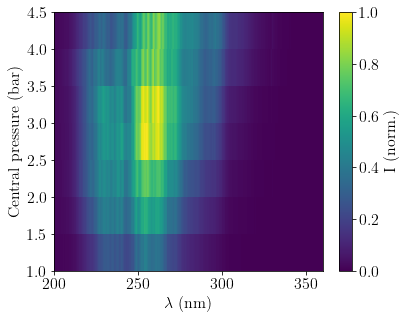

In [11]:
import matplotlib.pyplot as plt 

# plot settings 
show = True           # if True: open plots in matplotlib GUI; if False: don't show plots (directly write to file) 
save = True           # if True: saves plots 
show_title = False     # if False: no titles shown 
norm = True           # if True: norm spectra 
disable_latex = False # if True: disable LaTeX rendering 
use_pdf = True        # if True: save plots as pdf; else: use png

# set plot formatting 
if disable_latex == False : plt.rcParams["text.usetex"] = True   # enable LaTeX renadering
plt.rcParams["mathtext.fontset"] = "cm" # use LateX font for maths
plt.rcParams["font.family"] = "STIXGeneral" # use LateX font for text
plt.rcParams["font.size"] = 16 # set standard font size 
fig_dim = [2 * 3.14961,2* 2.3622075] # for 8cm width ; double for 16cm width

plt.figure(figsize=fig_dim) 
if show_title: plt.title("??")
plt.subplots_adjust(top=0.9, bottom=0.14, left=0.16)
plt.xlabel('$\lambda$ (nm)')
plt.ylabel("Central pressure (bar)")

I_2d  = np.empty((len(data[0,1])-1, len(data[:,0])-1), dtype="float")
for i in np.arange(len(data[0,1])-1):      # lam
    for j in np.arange(len(data[:,0])-1):  # pres 
        I_2d[i,j] = data[j, 2][i]

X, Y = np.meshgrid(data[0,1].astype("float")*1e9, data[:,0].astype("float"))  
I_2d = np.swapaxes(I_2d,0,1) 

if norm: 
    plt.pcolormesh(X, Y, I_2d/np.max(I_2d))
else:
    plt.pcolormesh(X, Y, I_2d)    

plt.colorbar(label="I (arb. units)" if norm==False else "I (norm.)")
#plt.xlim(min(data[0,1])*1e9, max(data[0,1])*1e9)
#plt.xlim(min(data[0,1])*1e9,360)
plt.xlim(200,360)

if save: 
    if use_pdf:
        plt.savefig(os.path.join(out_dir,"2d_spectra_pres_Ne_400mW_meas.pdf"))
    else:
        plt.savefig(os.path.join(out_dir,"2d_spectra_pres_Ne_400mW_meas.png"),dpi=1000)    

if show: plt.show()